In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/test.csv')

In [5]:
train['comment'] = train['comment'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]', '')
test['comment'] = test['comment'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]', '')

In [6]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '자', '에', '와', '한', '하다']

In [7]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 53.5MB/s 
     |████████████████████████████████| 92kB 12.8MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [8]:
train_list_X = train.comment.to_list()
train_list_y = train.label.to_list()
test_list_X = test.comment.to_list()
test_list_y = test.label.to_list()

In [9]:
len(train_list_X), len(train_list_y), len(test_list_X), len(test_list_y)

(28236, 28236, 4515, 4515)

In [10]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

- train data

In [10]:
maxlen = 2000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(train_list_X)
sequences = tokenizer.texts_to_sequences(train_list_X)

word_index = tokenizer.word_index
print('{}개의 고유한 토큰을 찾았습니다.'.format(len(word_index)))

92581개의 고유한 토큰을 찾았습니다.


In [11]:
data_train = pad_sequences(sequences, maxlen = maxlen)
labels_train = np.array(train_list_y)

data_train.shape, labels_train.shape

((28236, 2000), (28236,))

- test data

In [11]:
maxlen = 2000
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(test_list_X)
sequences = tokenizer.texts_to_sequences(test_list_X)

word_index = tokenizer.word_index
print('{}개의 고유한 토큰을 찾았습니다.'.format(len(word_index)))

28775개의 고유한 토큰을 찾았습니다.


In [12]:
data_test = pad_sequences(sequences, maxlen = maxlen)
labels_test = np.array(test_list_y)

data_test.shape, labels_test.shape

((4515, 2000), (4515,))

- train valid split

In [14]:
indices = np.arange(data_train.shape[0])
np.random.shuffle(indices)
data = data_train[indices]
labels = labels_train[indices]

In [15]:
training_samples = 20000

X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples:]
y_valid = labels[training_samples:]

In [16]:
from keras import models
from keras import layers

In [27]:
help(layers.Embedding)

Help on class Embedding in module tensorflow.python.keras.layers.embeddings:

class Embedding(tensorflow.python.keras.engine.base_layer.Layer)
 |  Embedding(*args, **kwargs)
 |  
 |  Turns positive integers (indexes) into dense vectors of fixed size.
 |  
 |  e.g. `[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]`
 |  
 |  This layer can only be used as the first layer in a model.
 |  
 |  Example:
 |  
 |  >>> model = tf.keras.Sequential()
 |  >>> model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
 |  >>> # The model will take as input an integer matrix of size (batch,
 |  >>> # input_length), and the largest integer (i.e. word index) in the input
 |  >>> # should be no larger than 999 (vocabulary size).
 |  >>> # Now model.output_shape is (None, 10, 64), where `None` is the batch
 |  >>> # dimension.
 |  >>> input_array = np.random.randint(1000, size=(32, 10))
 |  >>> model.compile('rmsprop', 'mse')
 |  >>> output_array = model.predict(input_array)
 |  >>> print(output_array.sh

In [30]:
comment_model = models.Sequential()

comment_model.add(layers.Embedding(10000,
                                   300,
                                   input_length = 25))

comment_model.add(layers.LSTM(16, return_sequences = True))
comment_model.add(layers.Dropout(0.5))
comment_model.add(layers.LSTM(8))
comment_model.add(layers.Dropout(0.5))
comment_model.add(layers.Dense(2, activation = 'softmax'))

In [31]:
comment_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 300)           3000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 25, 16)            20288     
_________________________________________________________________
dropout_4 (Dropout)          (None, 25, 16)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 3,021,106
Trainable params: 3,021,106
Non-trainable params: 0
____________________________________________

In [32]:
comment_model.compile(loss = 'sparse_categorical_crossentropy',
                      optimizer = 'adam',
                      metrics = ['accuracy'])

In [33]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 20,
                   verbose = 1)

In [34]:
from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/project/best_comment_model_lstm2.h5',
                     monitor = 'val_accuracy',
                     mode = 'max',
                     save_best_only = True,
                     verbose = 1)

In [35]:
%%time

Hist = comment_model.fit(X_train, y_train,
                         epochs = 500,
                         batch_size = 512,
                         validation_data = (X_valid, y_valid),
                         callbacks = [es, mc],
                         verbose = 1)

Epoch 1/500
40/40 [==============================] - 62s 766ms/step - loss: 0.6903 - accuracy: 0.5270 - val_loss: 0.6780 - val_accuracy: 0.6179

Epoch 00001: val_accuracy improved from -inf to 0.61790, saving model to /content/drive/MyDrive/Colab Notebooks/project/best_comment_model_lstm2.h5
Epoch 2/500
40/40 [==============================] - 29s 739ms/step - loss: 0.6694 - accuracy: 0.6206 - val_loss: 0.6288 - val_accuracy: 0.6745

Epoch 00002: val_accuracy improved from 0.61790 to 0.67448, saving model to /content/drive/MyDrive/Colab Notebooks/project/best_comment_model_lstm2.h5
Epoch 3/500
40/40 [==============================] - 30s 763ms/step - loss: 0.5876 - accuracy: 0.7088 - val_loss: 0.5933 - val_accuracy: 0.6869

Epoch 00003: val_accuracy improved from 0.67448 to 0.68686, saving model to /content/drive/MyDrive/Colab Notebooks/project/best_comment_model_lstm2.h5
Epoch 4/500
40/40 [==============================] - 32s 792ms/step - loss: 0.4929 - accuracy: 0.7759 - val_loss: 0

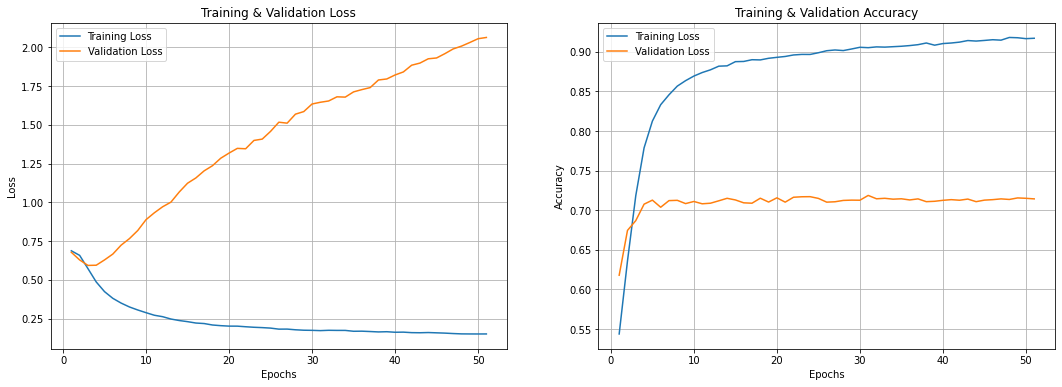

In [36]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist.history['loss']) + 1)

plt.figure(figsize = (18, 6))

for num, value in enumerate(['loss', 'accuracy']):
  plt.subplot(1, 2, num + 1)
  plt.plot(epochs, Hist.history['{}'.format(value)])
  plt.plot(epochs, Hist.history['val_{}'.format(value)])
  plt.title('Training & Validation {}'.format(value.title()))
  plt.xlabel('Epochs')
  plt.ylabel('{}'.format(value.title()))
  plt.legend(['Training Loss', 'Validation Loss'])
  plt.grid()
plt.show()

In [37]:
comment_model.evaluate(data_test, labels_test)

142/142 [==============================] - 10s 67ms/step - loss: 4.6033 - accuracy: 0.5070


[4.603302478790283, 0.5069767236709595]

In [1]:
from keras.models import load_model

In [13]:
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/project/best_comment_model_lstm2.h5')

loaded_model.evaluate(data_test, labels_test)

142/142 [==============================] - 41s 65ms/step - loss: 3.4822 - accuracy: 0.5333


[3.482196807861328, 0.5333333611488342]